In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
import NLsolve,Roots;
pyplot(frame=:box,size=(500,350));

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potential.jl");

In [3]:
function quadgauss(f, x::T, w::T) where {T<:Vector{Float64}}
    res = zero(f(x[1]))  # zero of the same type as f(x[1]), to avoid type instability
    for i in eachindex(x)
        res += f(x[i]) * w[i]
    end
    return res
end

λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [33]:
# ----------------------------------------------------------DD*----------------------------------------------------#
function potential_DnDsc_integrand(z, E, p, q; I=0, a=0, a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
    res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(z, p, q, mρn^2 - q01^2; cl=cl)
    res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(z, p, q, mω^2 - q01^2; cl=cl)
    res += -4 * gs^2 / sqrt(16) * pwa_central(z, p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor(z, p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(z, p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(z, p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(z, p, q, mρc^2 - q02^2; cl=cl)
                                                    -
                                                    pwa_square(z, p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(z, p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DcDsn_integrand(z, E, p, q; I=0, a=0, a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDc, mDsn, mDc, mDsn), q0f(E, mDc, mDsn, mDsn, mDc)
    res = zero(ComplexF64)

    res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(z, p, q, mρn^2 - q01^2; cl=cl)
    res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(z, p, q, mω^2 - q01^2; cl=cl)
    res += -4 * gs^2 / sqrt(16) * pwa_central(z, p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor(z, p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(z, p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(z, p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(z, p, q, mρc^2 - q02^2; cl=cl)
                                                    -
                                                    pwa_square(z, p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(z, p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DDscross_integrand(z, E, p, q; I=0, a=0, a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDc, mDsn), q0f(E, mDn, mDsc, mDsn, mDc)
    res = zero(ComplexF64)

    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρc^2) / sqrt(16) * pwa_central(z, p, q, mρc^2 - q01^2; cl=cl)
#     res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor(z, p, q, mπn^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(z, p, q, mπn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += -2 * g^2 / (3fπ^2) / sqrt(16) * (pwa_tensor(z, p, q, mη^2 - q02^2; cl=cl) - a / 3 * pwa_contact(z, p, q, mη^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(z, p, q, mρn^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(z, p, q, mρn^2 - q02^2; cl=cl)
                                           -
                                           pwa_square(z, p, q, mρn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += ((2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(z, p, q, mω^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(z, p, q, mω^2 - q02^2; cl=cl)
                                          -
                                          pwa_square(z, p, q, mω^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    #ηc,J/ψ
    res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor(z, p, q, mηc^2 - q02^2; cl=cl) - a / 3 * pwa_contact(z, p, q, mηc^2 - q02^2; cl=cl)) * (-2) * (I - 1 / 2) * 2
    res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(z, p, q, mJψ^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(z, p, q, mJψ^2 - q02^2; cl=cl)
                                           -
                                           pwa_square(z, p, q, mJψ^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2 * (-2))
    return res
end

potential_DDscross_integrand (generic function with 1 method)

# width of $D^*$

In [5]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

dΓf3 (generic function with 1 method)

In [6]:
ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

dΓDsnf (generic function with 1 method)

In [7]:
function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    return sol.zero[1] + im * sol.zero[2]
end

find_singular (generic function with 1 method)

In [8]:
qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [9]:
@btime qon_c(3.874)

  6.708 μs (58 allocations: 4.08 KiB)


0.0009031406050093312 + 0.04613250749939164im

In [10]:
qon_c(mDn+mDsc-360e-6-im*24e-6)|>println
qon_0(mDn+mDsc-360e-6-im*24e-6)|>println

0.0006990917686079699 + 0.026383911589114288im
6.632585092995444e-5 + 0.05770078015100248im


# path deformation

In [9]:
xxx,www=gauss(30,0,1);

In [10]:
qi=zeros(ComplexF64,2+3*length(xxx));
wi=zeros(ComplexF64,3*length(xxx));

In [11]:
function Einner(E,q,m1,m2,m3,m12)
    return E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
end

Einner (generic function with 1 method)

In [12]:
function find_qint(E,m1,m2,m3,m12;rtol=1e-6)
    
#     # method 1
#     function f!(F,x)
#         q=x[1]+1.0im*x[2]
#         tmp=Einner(E,q,m1,m2,m3,m12)
#         F[1]=real(tmp)-m1-m2
#         F[2]=imag(tmp)-rtol
#     end
#     sol=NLsolve.nlsolve(f!,[0.1,-0.1])
#     return sol.zero[1]+im*sol.zero[2]
    
    # method 2
    Etmp=E+m12-m1-m2-im*rtol
    qtmp=sqrt(λf(Etmp^2,m12^2,m3^2))/(2*Etmp)
    return imag(qtmp)>0 ? -qtmp : qtmp
end

find_qint (generic function with 1 method)

In [13]:
function sol_qint3(qint1,qint2)
    
#     # method 1
#     sol=NLsolve.nlsolve((F,x)->F[1]=imag(conj(qint2-qint1)*(x[1]-qint1)),[1.0])
#     return sol.zero[1]+im*sol.zero[2]
    
    # method 2
    a,b=reim(qint1)
    c,d=reim(qint2)
    return b*(c-a)/(b-d)+a
end

sol_qint3 (generic function with 1 method)

$0\sim 0.5$, $0.5\sim 1$, $1\sim\infty$

In [14]:
f1(x)=0.5*x;
f2(x)=0.5*(1-x)+1.0*x;
f3(x)=1.0+tan(π/2*x);
df3(x)=π/2/cos(π/2*x)^2;

In [15]:
function find_qw(E;qi=qi,wi=wi,xxx=xxx,www=www)
    
    # wi is the one wrappered with g'(x)
    qi[1],qi[2]=qon_c(E),qon_0(E)
    len=length(xxx)
    if imag(E)>=0||(real(E)<=mDn+mDn+mπc)
        for i in eachindex(xxx)
            qi[2+i]=f1(xxx[i])
            qi[2+len+i]=f2(xxx[i])
            qi[2+2*len+i]=f3(xxx[i])
            wi[i]=0.5*www[i]
            wi[i+len]=0.5*www[i]
            wi[i+2*len]=df3(xxx[i])*www[i]
        end
        return nothing
    end
    
    # find closet DDπ
    qint1,qint2=zeros(ComplexF64,2)
    if real(E)>mDc+mDc+mπc
        qint1=find_qint(E,mDc,mπc,mDc,mDsn)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    elseif real(E)>mDc+mDn+mπn
        qint1=find_qint(E,mDc,mπn,mDn,mDsc)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    else
        qint1=find_qint(E,mDn,mπc,mDn,mDsc)
        qint2=2*real(qint1)
    end
    
    @assert real(qint1)>0&&imag(qint1)<0 "Wrong qint1 position!"
    @assert imag(qint2)>imag(qint1)&&imag(qint2)<=0&&real(qint2)>real(qint1) "Wrong qint2 position!"
    
#     # get points on real axis
#     # method1
#     qint3=Roots.find_zero(x->imag(conj(qint2-qint1)*(x-qint1)),(0,1))
    # method 2
    qint3=sol_qint3(qint1,qint2)
#     println(qint1)
#     println(qint2)
#     println(qint3)
    
    for i in eachindex(xxx)
        qi[2+i]=qint1*xxx[i]
        qi[2+len+i]=qint1+(qint3-qint1)*xxx[i]
        qi[2+2*len+i]=qint3+tan(π/2*xxx[i])
        wi[i]=qint1*www[i]
        wi[i+len]=(qint3-qint1)*www[i]
        wi[i+2*len]=df3(xxx[i])*www[i]
    end
    return nothing
end

find_qw (generic function with 1 method)

In [16]:
@btime find_qw(3.875)

  14.250 μs (117 allocations: 8.17 KiB)


# VGT

In [17]:
Vmat=zeros(ComplexF64,4*(2+3*length(xxx)),4*(2+3*length(xxx)));
Gmat=zeros(ComplexF64,4*(2+3*length(xxx)),4*(2+3*length(xxx)));
Tmat=zeros(ComplexF64,4*(2+3*length(xxx)),4*(2+3*length(xxx)));

In [18]:
function VMat!(E;a = 0.0,a1=0.0,Λ=0.5,I=0,plist=qi,des=Vmat)
    find_qw(E)
    sublen=length(plist)

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I, cl = :ss)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I, cl = :ds)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :sd)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I, cl = :dd)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 1, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ss)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 1, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ds)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 2, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :sd)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 2, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :dd)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 3, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ss)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 3, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ds)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 4, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :sd)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 4, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :dd)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 3, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ss)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 3, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ds)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 4, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :sd)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
            i, j = 4, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :dd)*exp(-plist[l]^2/Λ^2-plist[m]^2/Λ^2))
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

In [32]:
function potential_DnDsc(E, p, q; I=0, a=0, a1=0.0, cl=:ss, r=100.0)
    res = zero(ComplexF64)
    res += quadgk(z -> potential_DnDsc_integrand(z, E, p, q; I=I, a=a, a1=a1, cl=cl),  -1.0, 1)[1]
    return res
end

function potential_DcDsn(E, p, q; I=0, a=0, a1=0.0, cl=:ss, r=100.0)
    res = zero(ComplexF64)
    res += quadgk(z -> potential_DcDsn_integrand(z, E, p, q; I=I, a=a, a1=a1, cl=cl), -1.0, 1)[1]
    return res
end

function potential_DDscross(E, p, q; I=0, a=0, a1=0.0, cl=:ss, r=100.0)
    res = zero(ComplexF64)
    res += quadgk(z -> potential_DDscross_integrand(z, E, p, q; I=I, a=a, a1=a1, cl=cl),  -1.0, 1)[1]
    return res
end

potential_DDscross (generic function with 1 method)

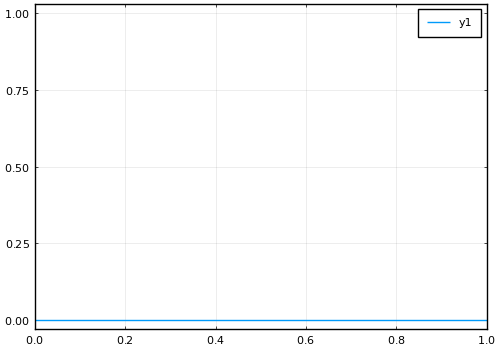

In [34]:
# @btime VMat!(3.875)
VMat!(3.875)
# VMat!(mDn+mDsc-360e-6-im*24e-6)
plot(real.(qi[3:end]),imag.(qi[3:end]),xlims=(0,1))

In [45]:
plotly()

Plots.PlotlyBackend()

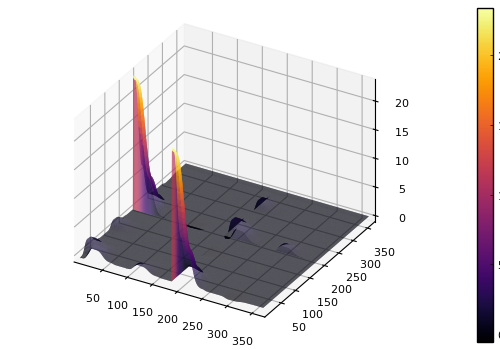

In [35]:
surface(collect(1:4*length(qi)),collect(1:4*length(qi)),[real(Vmat[x,y]) for y in 1:4*length(qi),x in 1:4*length(qi)])

In [36]:
findmax(abs.(real.(Vmat)))

(23.381476326429127, CartesianIndex(186, 2))

In [23]:
# qi[28],qi[2]
qi[9],qi[2]

(0.058055641973793454 + 0.0im, 0.0005089301587493639 + 0.05316318610728707im)

In [26]:
potential_DDscross(3.875,qi[2],qi[9];cl=:dd)*exp(-qi[2]^2/0.5^2-qi[9]^2/0.5^2)

9.769690364519541e7 + 2.8027016921048663e6im

In [64]:
mη^2-q0f(3.875, mDn, mDsc, mDsn, mDc)^2

0.2801707630344979

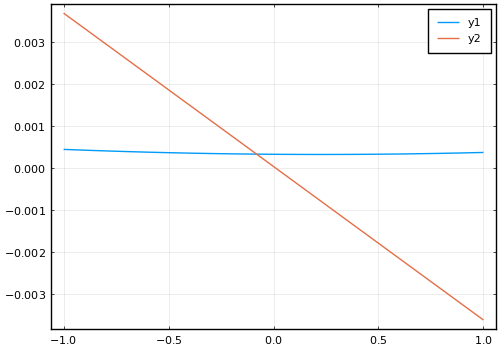

In [31]:
let 
    p,q=(0.058055641973793454 + 0.0im, 0.0005089301587493639 + 0.05316318610728707im)
    usq=mη^2-q0f(3.875, mDn, mDsc, mDsn, mDc)^2
    plot(z->real(pwa_tensor(z, p, q, usq; cl=:ss)),-1,1)
    plot!(z->imag(pwa_tensor(z, p, q, usq; cl=:ss)),-1,1)
#     (p^2+q^2+usq)/(2*p*q)
end

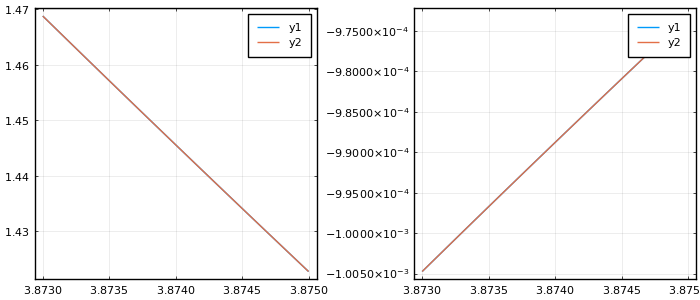

In [21]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps())
    function tmpf(E)
        VMat!(E)
        Vmat[1,1]
    end
    
    resv1=[tmpf(e+im*eps()) for e in Ev]
    resv2=[tmpf(e-im*eps()) for e in Ev]
    p1=plot(Ev,real.(resv1))
    plot!(Ev,real.(resv2))
    p2=plot(Ev,imag.(resv1))
    plot!(Ev,imag.(resv2))
    plot(p1,p2,layout=(1,2),size=(700,300))
end

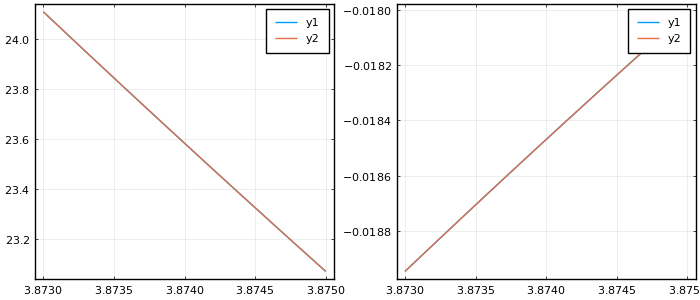

In [23]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps())
    function tmpf(E)
        VMat!(E)
        Vmat[2,1+2*length(qi)]
    end
    
    resv1=[tmpf(e+im*eps()) for e in Ev]
    resv2=[tmpf(e-im*eps()) for e in Ev]
    p1=plot(Ev,real.(resv1))
    plot!(Ev,real.(resv2))
    p2=plot(Ev,imag.(resv1))
    plot!(Ev,imag.(resv2))
    plot(p1,p2,layout=(1,2),size=(700,300))
end

In [55]:
VMat!(mDn+mDsc-360e-6-im*24e-6)

In [59]:
plotly()

Plots.PlotlyBackend()

In [60]:
surface(real.(qi[3:end]),real.(qi[3:end]),real.(Vmat[3:length(qi),3:length(qi)]))

In [61]:
surface(real.(qi[3:end]),real.(qi[3:end]),imag.(Vmat[3:length(qi),3:length(qi)]))

In [68]:
plot(real.(vec(Vmat)[1:length(qi)]))
plot!(imag.(vec(Vmat)[1:length(qi)]))
hline!([real(Vmat[1,1])])
hline!([imag(Vmat[1,1])])

In [71]:
findmax(real.(Vmat))

(23.509539258701963, CartesianIndex(186, 2))

In [72]:
findmax(imag.(Vmat))

(0.013059553071207937, CartesianIndex(253, 2))

In [39]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [40]:
function GMat!(E;qi=qi,wi=wi,des=Gmat)
    find_qw(E)
    sublen=length(qi)
    μ1,μ2=μf(mDn,mDsc),μf(mDc,mDsn)
    k1,k2=qi[1],qi[2]
    
    tmp=zero(ComplexF64)
    
    for i in 1:2
        tmp=0.0+0.0im
        for j in eachindex(wi)
            tmp+=-wi[j]*k1^2*Gc(E,qi[2+j])
            des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gc(E,qi[2+j])
        end
        tmp+=im/(2π)*k1^2/(-k1/μ1+im*dΓDscf(E,k1)/2)
        des[(i-1)*sublen+1,(i-1)*sublen+1]=tmp
    end
    
    for i in 3:4
        tmp=0.0+0.0im
        for j in eachindex(wi)
            tmp+=-wi[j]*k2^2*Gn(E,qi[2+j])
            des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gn(E,qi[2+j])
        end
        tmp+=im/(2π)*k2^2/(-k2/μ2+im*dΓDsnf(E,k2)/2)
        des[(i-1)*sublen+2,(i-1)*sublen+2]=tmp
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [41]:
@btime GMat!(3.875)

  107.167 μs (118 allocations: 8.19 KiB)


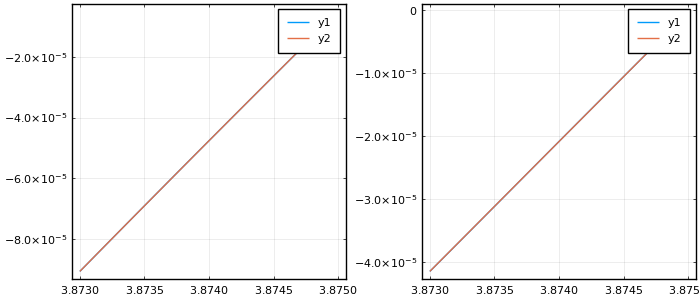

In [42]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps())
    function tmpf(E)
        GMat!(E)
        Gmat[1,1]
    end
    resv1=[tmpf(e+im*eps()) for e in Ev]
    resv2=[tmpf(e-im*eps()) for e in Ev]

    p1=plot(Ev,real.(resv1))
    plot!(Ev,real.(resv2))
    p2=plot(Ev,imag.(resv1))
    plot!(Ev,imag.(resv2))
    plot(p1,p2,layout=(1,2),size=(700,300))
end

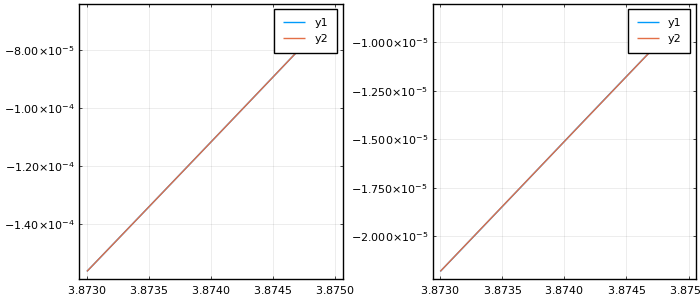

In [43]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps())
    function tmpf(E)
        GMat!(E)
        Gmat[2+2*length(qi),2+2*length(qi)]
    end
    resv1=[tmpf(e+im*eps()) for e in Ev]
    resv2=[tmpf(e-im*eps()) for e in Ev]

    p1=plot(Ev,real.(resv1))
    plot!(Ev,real.(resv2))
    p2=plot(Ev,imag.(resv1))
    plot!(Ev,imag.(resv2))
    plot(p1,p2,layout=(1,2),size=(700,300))
end

In [46]:
function detVG(E;a = 0.0,a1=0.0,Λ=0.5,I=0)
    VMat!(E;a=a,a1=a1,Λ=Λ,I=I)
    GMat!(E)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [47]:
function TMat!(E;a = 0.0,a1=0.0,Λ=0.5,I=0,des=Tmat)
    VMat!(E;a=a,a1=a1,Λ=Λ,I=I)
    GMat!(E)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    return nothing
end

TMat! (generic function with 1 method)

In [48]:
@btime detVG(3.875)

  1.813 s (4835701 allocations: 311.43 MiB)


-0.9310235479229007 - 0.3234991055185141im

In [49]:
@btime TMat!(3.875)

  1.833 s (4835707 allocations: 313.86 MiB)


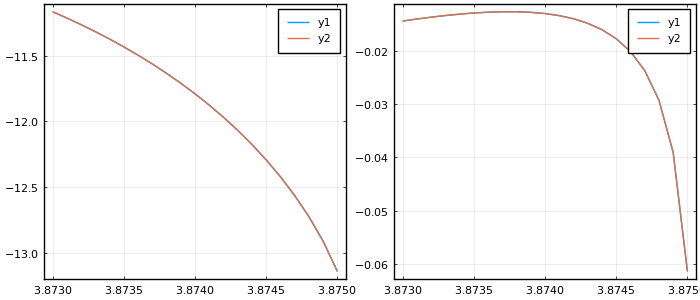

In [30]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps())
    function tmpf(E)
        TMat!(E)
        Tmat[1,1]
    end
    
    resv1=[tmpf(e+im*eps()) for e in Ev]
    resv2=[tmpf(e-im*eps()) for e in Ev]
    p1=plot(Ev,real.(resv1))
    plot!(Ev,real.(resv2))
    p2=plot(Ev,imag.(resv1))
    plot!(Ev,imag.(resv2))
    plot(p1,p2,layout=(1,2),size=(700,300))
end

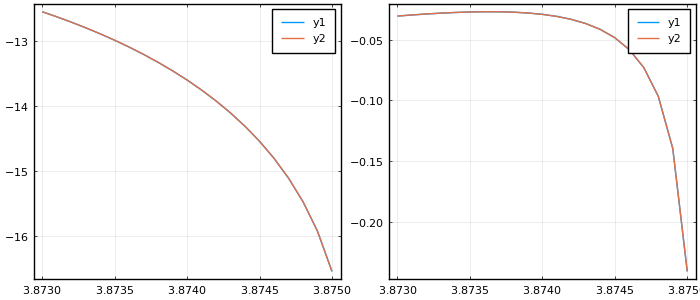

In [31]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps())
    function tmpf(E)
        TMat!(E)
        Tmat[2+2*length(qi),2+2*length(qi)]
    end
    
    resv1=[tmpf(e+im*eps()) for e in Ev]
    resv2=[tmpf(e-im*eps()) for e in Ev]
    p1=plot(Ev,real.(resv1))
    plot!(Ev,real.(resv2))
    p2=plot(Ev,imag.(resv1))
    plot!(Ev,imag.(resv2))
    plot(p1,p2,layout=(1,2),size=(700,300))
end

# parameters optimization

In [50]:
using Optim;

In [52]:
function inv_abst(x;E=mDn+mDsc-273e-6,I=0)
    TMat!(E;a=x[1],a1=0.0,Λ=x[2],I=I)
    return 1/abs(Tmat[1,1])
end

inv_abst (generic function with 1 method)

In [51]:
function absdet(x;E=mDn+mDsc-360e-6-im*24e-6,I=0)
    abs(detVG(E;a=x[1],a1=0.0,Λ=x[2],I=I))
end

absdet (generic function with 1 method)

## Test1:no pion

### same $\Lambda$ and a=0.0

In [53]:
let 
#     tmpf(x)=inv_abst([0.0,x[1],x[1]])
    tmpf(x)=absdet([0.0,x[1]];I=0)
    init_val=[0.6]
    lower=[0.3]
    upper=[2.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.13819119758799994
[0.34240057373355876]


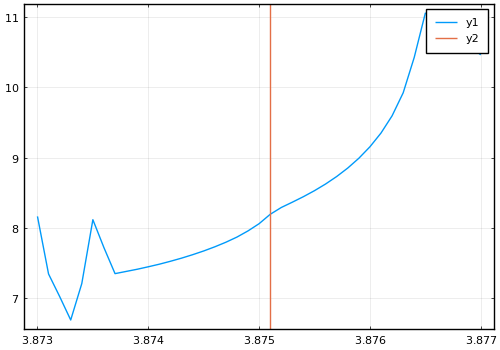

In [54]:
let Ev=collect(3.873:0.0001:3.877)
    function tmpf(E)
        TMat!(E;a=0.0,Λ=0.34240057373355876,I=0)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv)
    vline!([mDn+mDsc])
end

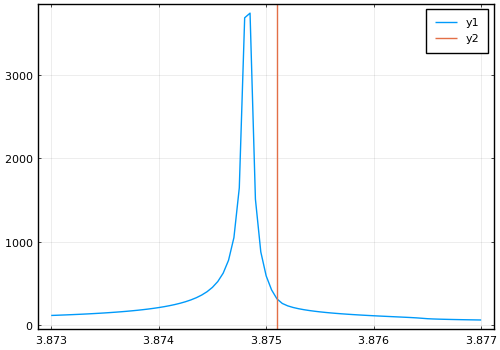

In [48]:
let Ev=collect(3.873:0.00005:3.877)
    function tmpf(E)
        TMat!(E;a=0.0,Λ1=0.858478497469796,Λ2=0.858478497469796,I=1)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv)
    vline!([mDn+mDsc])
end

### same $\Lambda$ and 0-a-1

In [55]:
let 
    tmpf(x)=inv_abst([x[1],x[2],x[2]];I=0)
    init_val=[0.01,0.5]
    lower=[0.0,0.3]
    upper=[1.0,2.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.00017276235890662588
[0.9999999997589334, 0.8949795727882751]


In [ ]:
0.8584784976360713

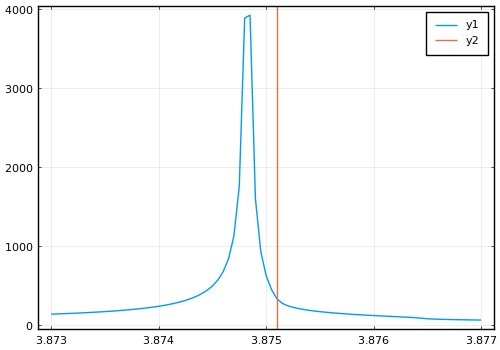

In [50]:
let Ev=collect(3.873:0.00005:3.877)
    function tmpf(E)
        TMat!(E;a=0.9999999997589334,Λ1=0.8949795727882751,Λ2=0.8949795727882751,I=0)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv)
    vline!([mDn+mDsc])
end

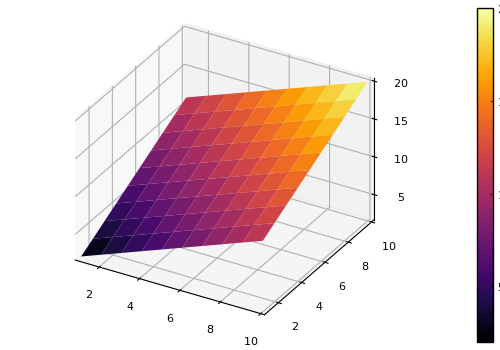

In [38]:
surface(collect(1:10),collect(1:10),[x+y for y in 1:10,x in 1:10])

In [39]:
[x+y for y in 1:10,x in 1:10]

10×10 Matrix{Int64}:
  2   3   4   5   6   7   8   9  10  11
  3   4   5   6   7   8   9  10  11  12
  4   5   6   7   8   9  10  11  12  13
  5   6   7   8   9  10  11  12  13  14
  6   7   8   9  10  11  12  13  14  15
  7   8   9  10  11  12  13  14  15  16
  8   9  10  11  12  13  14  15  16  17
  9  10  11  12  13  14  15  16  17  18
 10  11  12  13  14  15  16  17  18  19
 11  12  13  14  15  16  17  18  19  20